In [2]:
from sklearn import datasets
import sklearn
import numpy as np
import umap
import vectorizers
import vectorizers.transformers
import matplotlib.pyplot as plt
import seaborn as sns
import sentencepiece

import io

## Speed run vectorization
https://vectorizers.readthedocs.io/en/latest/document_vectorization.html

In [3]:
%%time
dataset = datasets.fetch_20newsgroups(
    subset="all", remove=("headers", "footers", "quotes")
)

long_enough = [len(t) > 280 for t in dataset["data"]]
targets = np.array(dataset.target)[long_enough]
news_data = [t.lower() for t in dataset["data"] if len(t) > 280]

model_buffer = io.BytesIO()
sentencepiece.SentencePieceTrainer.Train(
    sentence_iterator=(x for x in news_data), model_writer=model_buffer, vocab_size=10000
)

sp_parser = sentencepiece.SentencePieceProcessor(model_proto=model_buffer.getvalue())

tokenized_news = sp_parser.encode(news_data, out_type=str)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input_format: 
  model_prefix: 
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level

CPU times: user 23.2 s, sys: 529 ms, total: 23.7 s
Wall time: 8.26 s


: 0
  differential_privacy_clipping_threshold: 0
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
trainer_interface.cc(380) LOG(WARNING) Found too long line (6974 > 4192).
trainer_interface.cc(382) LOG(WARNING) Too long lines are skipped in the training.
trainer_interface.cc(383) LOG(WARNING) The maximum length can be changed with --max_sentence_length=<size> flag.
trainer_interface.cc(409) LOG(INFO) Loaded all 12404 sentences
trainer_interface.cc(416) LOG(INFO) Skipped 705 too long sentences.
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <unk>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <s>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: </s>
trainer_interface.cc(430) LOG(INFO) Normalizing sentences...
trainer_interface.cc(539) LOG(INFO) all chars count=11421005
trainer_interface.cc(550) LOG(INFO) Done: 99.9622% characters are covered.
trainer_in

In [4]:
%%time
word_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
    min_document_occurrences=5,
    window_radii=(1, 20),
    window_functions=("fixed", "variable"),
    kernel_functions=("geometric", "geometric"),
    kernel_args=({}, {"offset":1}),
    mask_string="[##MASK##]",
    nullify_mask=True,
    n_iter=2,
    normalize_windows=True,
    n_threads=4,
).fit(tokenized_news)
word_vectors = word_vectorizer.reduce_dimension(dimension=150)

/Users/ryandewolfe/miniforge3/envs/PALD/lib/python3.12/site-packages/numba/core/utils.py:661: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
/Users/ryandewolfe/miniforge3/envs/PALD/lib/python3.12/site-packages/numba/core/utils.py:661: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
/Users/ryandewolfe/miniforge3/envs/PALD/lib/python3.12/site-packages/numba/core/utils.py:661: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",


CPU times: user 3min 14s, sys: 5.46 s, total: 3min 20s
Wall time: 1min 28s


In [5]:
%%time
ngrammer = vectorizers.NgramVectorizer(
    token_dictionary=word_vectorizer.token_label_dictionary_
)
doc_matrix = ngrammer.fit_transform(tokenized_news)

info_weighter = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
)
info_doc_matrix = info_weighter.fit_transform(doc_matrix)

we_vectorizer = vectorizers.WassersteinVectorizer(
    n_components=160,
    memory_size="4G",
    random_state=42,
)
we_vectors = we_vectorizer.fit_transform(info_doc_matrix, vectors=word_vectors)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 3min 1s, sys: 4.93 s, total: 3min 6s
Wall time: 1min 5s


## See a plot of the vectorized dataset colored by label

CPU times: user 15.8 s, sys: 478 ms, total: 16.3 s
Wall time: 9.28 s


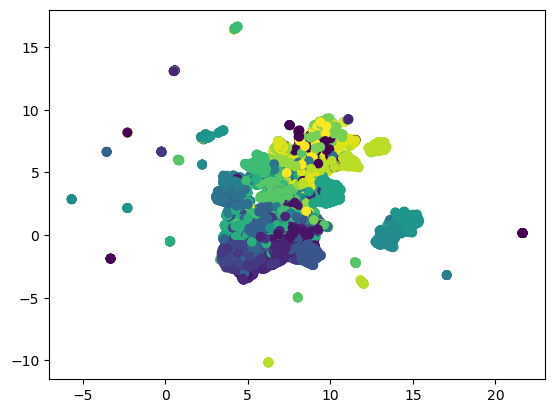

In [6]:
%%time
mapper = umap.UMAP()
data_map = mapper.fit_transform(we_vectors)

plt.scatter(data_map[:, 0], data_map[:, 1], c=targets)

# Pretty bad, anywho we will only use a subset of all the groups which will improve separation

In [7]:
np.save("news_vectors.npy", we_vectors)
np.save("news_labels.npy", targets)